# House Prices
## 3. A Study on Regression Applied to the Ames Dataset
[캐글]: https://www.kaggle.com/c/house-prices-advanced-regression-techniques <br>
[참고 커널모음] :https://subinium.github.io/kaggle-tutorial/house-prices <br>

#### Python Tutorials
아래 튜토리얼 하나씩 필사할 예정

> * 1. Comprehensive Data Exploration with Python (필사 시작일 : 2020-09-01)
https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python

> * 2. House Prices EDA (필사 시작일 : 2020-09-04) (마무리한 날짜: 2020-10-25)
https://www.kaggle.com/dgawlik/house-prices-eda

> * 3. A Study on Regression Applied to the Ames Dataset (필사 시작일 :2020-11-15)
https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

> * 4. Regularized Linear Models
https://www.kaggle.com/apapiu/regularized-linear-models




### what I learned
* select_dtypes() 함수
    * 범주형 데이터타입인 컬럼만 따로 빼올수있음. 반대로, 범주형이아닌 변수도 따로 뺄 수 있음.
    
* 회귀모델 

* 릿지, 라쏘 모델


-------------------------------------------------
이 커널에서는 Regularization알고리즘을 포함한 선형회귀에 대해 다룬다.  <br>
RF,  xgboost, ensembling etc. 등을 사용하지 않고 선형회귀만으로 0.121 이라는 스코어획득함.

In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
#njobs = 4

In [3]:
# Get data
train = pd.read_csv("./data/train.csv")
print("train : " + str(train.shape))

train : (1460, 81)


In [5]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [9]:
# 중복확인.
idsUnique=len(set(train.Id))  # 1460
idsTotal=train.shape[0]
idsDupli=idsTotal-idsUnique
print("There are " + str(idsDupli) + " duplicate IDs for " + str(idsTotal) + " total entries")

# Id 컬럼 제거
train.drop("Id",axis=1, inplace=True)

There are 0 duplicate IDs for 1460 total entries


------------------------------------------------------------
### Preprocessing

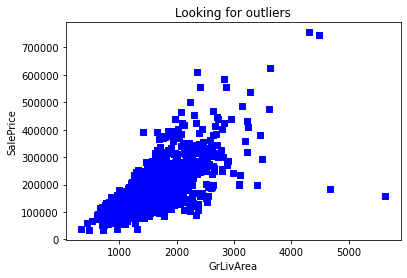

In [11]:
# outlier체크
plt.scatter(train.GrLivArea, train.SalePrice, c="blue", marker="s")
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

train=train[train.GrLivArea<4000]

* 오른쪽 하단에 면적이 큰데, 매우 저렴하게 팔리는 2개의 outlier가 보인다. 데이터셋의 author은 4000square feet이상의 집들은 제거할것을 권했다. 

In [12]:
train.SalePrice=np.log1p(train.SalePrice)
y=train.SalePrice

/Users/suhyun/anaconda3/envs/suhyun2/lib/python3.6/site-packages/pandas/core/generic.py:5302: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


* 로그를 취하는것에 의미는, 비싼 집과 저렴한 집을 예측하는것에 대한 에러가 결과에 동일하게 영향을 미치게 한다는 것을 의미한다.

**(결측치 처리)**

In [15]:
# Handle missing values for features where median/mean or most common value doesn't make sense

# Alley : data description says NA means "no alley access"
train.loc[:, "Alley"] = train.loc[:, "Alley"].fillna("None")
# BedroomAbvGr : NA most likely means 0
train.loc[:, "BedroomAbvGr"] = train.loc[:, "BedroomAbvGr"].fillna(0)
# BsmtQual etc : data description says NA for basement features is "no basement"
train.loc[:, "BsmtQual"] = train.loc[:, "BsmtQual"].fillna("No")
train.loc[:, "BsmtCond"] = train.loc[:, "BsmtCond"].fillna("No")
train.loc[:, "BsmtExposure"] = train.loc[:, "BsmtExposure"].fillna("No")
train.loc[:, "BsmtFinType1"] = train.loc[:, "BsmtFinType1"].fillna("No")
train.loc[:, "BsmtFinType2"] = train.loc[:, "BsmtFinType2"].fillna("No")
train.loc[:, "BsmtFullBath"] = train.loc[:, "BsmtFullBath"].fillna(0)
train.loc[:, "BsmtHalfBath"] = train.loc[:, "BsmtHalfBath"].fillna(0)
train.loc[:, "BsmtUnfSF"] = train.loc[:, "BsmtUnfSF"].fillna(0)
# CentralAir : NA most likely means No
train.loc[:, "CentralAir"] = train.loc[:, "CentralAir"].fillna("N")
# Condition : NA most likely means Normal
train.loc[:, "Condition1"] = train.loc[:, "Condition1"].fillna("Norm")
train.loc[:, "Condition2"] = train.loc[:, "Condition2"].fillna("Norm")
# EnclosedPorch : NA most likely means no enclosed porch
train.loc[:, "EnclosedPorch"] = train.loc[:, "EnclosedPorch"].fillna(0)
# External stuff : NA most likely means average
train.loc[:, "ExterCond"] = train.loc[:, "ExterCond"].fillna("TA")
train.loc[:, "ExterQual"] = train.loc[:, "ExterQual"].fillna("TA")
# Fence : data description says NA means "no fence"
train.loc[:, "Fence"] = train.loc[:, "Fence"].fillna("No")
# FireplaceQu : data description says NA means "no fireplace"
train.loc[:, "FireplaceQu"] = train.loc[:, "FireplaceQu"].fillna("No")
train.loc[:, "Fireplaces"] = train.loc[:, "Fireplaces"].fillna(0)
# Functional : data description says NA means typical
train.loc[:, "Functional"] = train.loc[:, "Functional"].fillna("Typ")
# GarageType etc : data description says NA for garage features is "no garage"
train.loc[:, "GarageType"] = train.loc[:, "GarageType"].fillna("No")
train.loc[:, "GarageFinish"] = train.loc[:, "GarageFinish"].fillna("No")
train.loc[:, "GarageQual"] = train.loc[:, "GarageQual"].fillna("No")
train.loc[:, "GarageCond"] = train.loc[:, "GarageCond"].fillna("No")
train.loc[:, "GarageArea"] = train.loc[:, "GarageArea"].fillna(0)
train.loc[:, "GarageCars"] = train.loc[:, "GarageCars"].fillna(0)
# HalfBath : NA most likely means no half baths above grade
train.loc[:, "HalfBath"] = train.loc[:, "HalfBath"].fillna(0)
# HeatingQC : NA most likely means typical
train.loc[:, "HeatingQC"] = train.loc[:, "HeatingQC"].fillna("TA")
# KitchenAbvGr : NA most likely means 0
train.loc[:, "KitchenAbvGr"] = train.loc[:, "KitchenAbvGr"].fillna(0)
# KitchenQual : NA most likely means typical
train.loc[:, "KitchenQual"] = train.loc[:, "KitchenQual"].fillna("TA")
# LotFrontage : NA most likely means no lot frontage
train.loc[:, "LotFrontage"] = train.loc[:, "LotFrontage"].fillna(0)
# LotShape : NA most likely means regular
train.loc[:, "LotShape"] = train.loc[:, "LotShape"].fillna("Reg")
# MasVnrType : NA most likely means no veneer
train.loc[:, "MasVnrType"] = train.loc[:, "MasVnrType"].fillna("None")
train.loc[:, "MasVnrArea"] = train.loc[:, "MasVnrArea"].fillna(0)
# MiscFeature : data description says NA means "no misc feature"
train.loc[:, "MiscFeature"] = train.loc[:, "MiscFeature"].fillna("No")
train.loc[:, "MiscVal"] = train.loc[:, "MiscVal"].fillna(0)
# OpenPorchSF : NA most likely means no open porch
train.loc[:, "OpenPorchSF"] = train.loc[:, "OpenPorchSF"].fillna(0)
# PavedDrive : NA most likely means not paved
train.loc[:, "PavedDrive"] = train.loc[:, "PavedDrive"].fillna("N")
# PoolQC : data description says NA means "no pool"
train.loc[:, "PoolQC"] = train.loc[:, "PoolQC"].fillna("No")
train.loc[:, "PoolArea"] = train.loc[:, "PoolArea"].fillna(0)
# SaleCondition : NA most likely means normal sale
train.loc[:, "SaleCondition"] = train.loc[:, "SaleCondition"].fillna("Normal")
# ScreenPorch : NA most likely means no screen porch
train.loc[:, "ScreenPorch"] = train.loc[:, "ScreenPorch"].fillna(0)
# TotRmsAbvGrd : NA most likely means 0
train.loc[:, "TotRmsAbvGrd"] = train.loc[:, "TotRmsAbvGrd"].fillna(0)
# Utilities : NA most likely means all public utilities
train.loc[:, "Utilities"] = train.loc[:, "Utilities"].fillna("AllPub")
# WoodDeckSF : NA most likely means no wood deck
train.loc[:, "WoodDeckSF"] = train.loc[:, "WoodDeckSF"].fillna(0)

/Users/suhyun/anaconda3/envs/suhyun2/lib/python3.6/site-packages/pandas/core/indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [16]:
# Some numerical features are actually really categories
## 카테고리를 의미하는것은 문자로 바꿔줌.
train = train.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

In [17]:
# Encode some categorical features as ordered numbers when there is information in the order
## 순서를 나타내는 카테고리는 0,1,2,3,,이런식으로 넘버링 해준다.
train = train.replace({"Alley" : {"Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )

**3가지 방법으로 새로운 feature를 만들것이다**
1. Simplifications of existing features
    * 존재하는 feature들을 단순화
        * ex) 퀄리티가 1부터 10까지 다양하게 있으면, 이걸 범주화해서 1~3은 1로, 4~6은 2로, 7~10은 3으로.
2. Combinations of existing features
    * 존재하는 Feature들 조합
        * ex) Qual와  Cond의 곱으로  %Grade라는 컬럼을 새로 만듬.
        * ex) 주차장 면적과 주차장Quality를 곱해서 주차장 score 변수를 만듬.
3. Polynomials on the top 10 existing features
    * 상위10개 Feature로 다항식 

In [21]:
# Create new features
# 1* Simplifications of existing features
train["SimplOverallQual"] = train.OverallQual.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
train["SimplOverallCond"] = train.OverallCond.replace({1 : 1, 2 : 1, 3 : 1, # bad
                                                       4 : 2, 5 : 2, 6 : 2, # average
                                                       7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                      })
train["SimplPoolQC"] = train.PoolQC.replace({1 : 1, 2 : 1, # average
                                             3 : 2, 4 : 2 # good
                                            })
train["SimplGarageCond"] = train.GarageCond.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
train["SimplGarageQual"] = train.GarageQual.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
train["SimplFireplaceQu"] = train.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
train["SimplFireplaceQu"] = train.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
train["SimplFunctional"] = train.Functional.replace({1 : 1, 2 : 1, # bad
                                                     3 : 2, 4 : 2, # major
                                                     5 : 3, 6 : 3, 7 : 3, # minor
                                                     8 : 4 # typical
                                                    })
train["SimplKitchenQual"] = train.KitchenQual.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
train["SimplHeatingQC"] = train.HeatingQC.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
train["SimplBsmtFinType1"] = train.BsmtFinType1.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
train["SimplBsmtFinType2"] = train.BsmtFinType2.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
train["SimplBsmtCond"] = train.BsmtCond.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
train["SimplBsmtQual"] = train.BsmtQual.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
train["SimplExterCond"] = train.ExterCond.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
train["SimplExterQual"] = train.ExterQual.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })

# 2* Combinations of existing features
# Overall quality of the house
train["OverallGrade"] = train["OverallQual"] * train["OverallCond"]
# Overall quality of the garage
train["GarageGrade"] = train["GarageQual"] * train["GarageCond"]
# Overall quality of the exterior
train["ExterGrade"] = train["ExterQual"] * train["ExterCond"]
# Overall kitchen score
train["KitchenScore"] = train["KitchenAbvGr"] * train["KitchenQual"]
# Overall fireplace score
train["FireplaceScore"] = train["Fireplaces"] * train["FireplaceQu"]
# Overall garage score
train["GarageScore"] = train["GarageArea"] * train["GarageQual"]
# Overall pool score
train["PoolScore"] = train["PoolArea"] * train["PoolQC"]
# Simplified overall quality of the house
train["SimplOverallGrade"] = train["SimplOverallQual"] * train["SimplOverallCond"]
# Simplified overall quality of the exterior
train["SimplExterGrade"] = train["SimplExterQual"] * train["SimplExterCond"]
# Simplified overall pool score
train["SimplPoolScore"] = train["PoolArea"] * train["SimplPoolQC"]
# Simplified overall garage score
train["SimplGarageScore"] = train["GarageArea"] * train["SimplGarageQual"]
# Simplified overall fireplace score
train["SimplFireplaceScore"] = train["Fireplaces"] * train["SimplFireplaceQu"]
# Simplified overall kitchen score
train["SimplKitchenScore"] = train["KitchenAbvGr"] * train["SimplKitchenQual"]
# Total number of bathrooms
train["TotalBath"] = train["BsmtFullBath"] + (0.5 * train["BsmtHalfBath"]) + \
train["FullBath"] + (0.5 * train["HalfBath"])
# Total SF for house (incl. basement)
train["AllSF"] = train["GrLivArea"] + train["TotalBsmtSF"]
# Total SF for 1st + 2nd floors
train["AllFlrsSF"] = train["1stFlrSF"] + train["2ndFlrSF"]
# Total SF for porch
train["AllPorchSF"] = train["OpenPorchSF"] + train["EnclosedPorch"] + \
train["3SsnPorch"] + train["ScreenPorch"]
# Has masonry veneer or not
## 벽돌 유/무로 구분(있으면=1,없으면=0)
train["HasMasVnr"] = train.MasVnrType.replace({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, 
                                               "Stone" : 1, "None" : 0})
# House completed before sale or not
train["BoughtOffPlan"] = train.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, 
                                                      "Family" : 0, "Normal" : 0, "Partial" : 1})

**SalePrice와의 상관관계확인**

In [29]:
# Find most important features relative to target
print("Find most important features relative to target")
corr = train.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

Find most important features relative to target
SalePrice         1.000
OverallQual       0.819
AllSF             0.817
AllFlrsSF         0.729
GrLivArea         0.719
                  ...  
LandSlope        -0.040
SimplExterCond   -0.042
KitchenAbvGr     -0.148
EnclosedPorch    -0.149
LotShape         -0.286
Name: SalePrice, Length: 88, dtype: float64


**상위 10개 feature를 가지고 2제곱, 3제곱, 제곱근항을 각각 세개씩 만듬.**

In [33]:
# 상위 10개 feature를 가지고 2제곱, 3제곱, 제곱근항을 각각 세개씩 만듬.
# Create new features
# 3* Polynomials on the top 10 existing features
train["OverallQual-s2"] = train["OverallQual"] ** 2
train["OverallQual-s3"] = train["OverallQual"] ** 3
train["OverallQual-Sq"] = np.sqrt(train["OverallQual"])
train["AllSF-2"] = train["AllSF"] ** 2
train["AllSF-3"] = train["AllSF"] ** 3
train["AllSF-Sq"] = np.sqrt(train["AllSF"])
train["AllFlrsSF-2"] = train["AllFlrsSF"] ** 2
train["AllFlrsSF-3"] = train["AllFlrsSF"] ** 3
train["AllFlrsSF-Sq"] = np.sqrt(train["AllFlrsSF"])
train["GrLivArea-2"] = train["GrLivArea"] ** 2
train["GrLivArea-3"] = train["GrLivArea"] ** 3
train["GrLivArea-Sq"] = np.sqrt(train["GrLivArea"])
train["SimplOverallQual-s2"] = train["SimplOverallQual"] ** 2
train["SimplOverallQual-s3"] = train["SimplOverallQual"] ** 3
train["SimplOverallQual-Sq"] = np.sqrt(train["SimplOverallQual"])
train["ExterQual-2"] = train["ExterQual"] ** 2
train["ExterQual-3"] = train["ExterQual"] ** 3
train["ExterQual-Sq"] = np.sqrt(train["ExterQual"])
train["GarageCars-2"] = train["GarageCars"] ** 2
train["GarageCars-3"] = train["GarageCars"] ** 3
train["GarageCars-Sq"] = np.sqrt(train["GarageCars"])
train["TotalBath-2"] = train["TotalBath"] ** 2
train["TotalBath-3"] = train["TotalBath"] ** 3
train["TotalBath-Sq"] = np.sqrt(train["TotalBath"])
train["KitchenQual-2"] = train["KitchenQual"] ** 2
train["KitchenQual-3"] = train["KitchenQual"] ** 3
train["KitchenQual-Sq"] = np.sqrt(train["KitchenQual"])
train["GarageScore-2"] = train["GarageScore"] ** 2
train["GarageScore-3"] = train["GarageScore"] ** 3
train["GarageScore-Sq"] = np.sqrt(train["GarageScore"])

In [35]:
# 수치형 변수와 범주형 변수를 따로 저장.
categorical_features=train.select_dtypes(include=["object"]).columns
numerical_features=train.select_dtypes(exclude=['object']).columns
# 수치형 변수에서 SalePrice는 드랍
numerical_features=numerical_features.drop("SalePrice")

print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))

train_num=train[numerical_features]
train_cat=train[categorical_features]

Numerical features : 117
Categorical features : 26


**수치형 변수에있는 결측치를 median값으로 채운다**

In [41]:
# 수치형 변수에있는 결측치를 median값으로 채운다
print("NAs for numerical features in train : " + str(train_num.isnull().values.sum()))
train_num = train_num.fillna(train_num.median())
print("Remaining NAs for numerical features in train : " + str(train_num.isnull().values.sum()))

NAs for numerical features in train : 81
Remaining NAs for numerical features in train : 0


In [47]:
skewness=train_num.apply(lambda x:skew(x))
skewness

LotFrontage       -0.006
LotArea           12.575
Street           -15.481
LotShape          -1.290
Utilities        -38.118
                   ...  
KitchenQual-3      1.229
KitchenQual-Sq     0.140
GarageScore-2      2.403
GarageScore-3      5.268
GarageScore-Sq    -1.494
Length: 117, dtype: float64

* 아웃라이어의 영향을 줄이기위해서 비대칭(skew)한 수치형 변수들을 로그변환한다.

In [48]:
# 아웃라이어의 영향을 줄이기위해서 비대칭한 수치형 변수들을 로그변환한다.
# 비대칭 절대값이 0.5보다크면 least moderately skewed로 간주됨.

skewness=train_num.apply(lambda x:skew(x))
skewness=skewness[abs(skewness)>0.5]
# 86개의 수치형 변수를 로그변환하겠다.
print(str(skewness.shape[0]) + " skewed numerical features to log transform")

skewed_features=skewness.index
train_num[skewed_features]=np.log1p(train_num[skewed_features])

86 skewed numerical features to log transform


* one-hot encoding으로 범주형에 대해서 더미변수를 만든다.

In [50]:
# Create dummy features for categorical values via one-hot encoding
print("NAs for categorical features in train : " + str(train_cat.isnull().values.sum()))
train_cat = pd.get_dummies(train_cat)
print("Remaining NAs for categorical features in train : " + str(train_cat.isnull().values.sum()))

NAs for categorical features in train : 1
Remaining NAs for categorical features in train : 0


------------------------------------------------------------------------------------
### Modeling

In [54]:
train=pd.concat([train_num, train_cat], axis=1)
print("New number of features : " + str(train.shape[1]))

X_train,X_test,y_train,y_test=train_test_split(train,y,test_size=0.3, random_state=0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

New number of features : 319
X_train : (1019, 319)
X_test : (437, 319)
y_train : (1019,)
y_test : (437,)


* 스케일링 (StandardScaler)

In [56]:
stdSc=StandardScaler()
X_train.loc[:,numerical_features]=stdSc.fit_transform(X_train.loc[:,numerical_features])
X_test.loc[:,numerical_features]=stdSc.transform(X_test.loc[:,numerical_features])

/Users/suhyun/anaconda3/envs/suhyun2/lib/python3.6/site-packages/pandas/core/indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/suhyun/anaconda3/envs/suhyun2/lib/python3.6/site-packages/pandas/core/indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [55]:
# 스케일링 전
X_train.loc[:,numerical_features]

,LotFrontage,LotArea,Street,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,GarageCars-Sq,TotalBath-2,TotalBath-3,TotalBath-Sq,KitchenQual-2,KitchenQual-3,KitchenQual-Sq,GarageScore-2,GarageScore-3,GarageScore-Sq
328,0.000,9.383,1.099,1.386,1.609,1.386,6,1.946,7.559,1994,...,0.881,1.609,2.197,1.414,2.833,4.174,2.000,14.375,21.563,3.621
1026,73.000,9.138,1.099,1.609,1.609,1.386,5,1.792,7.581,1960,...,0.881,1.609,2.197,1.414,2.303,3.332,1.732,14.464,21.696,3.643
843,80.000,8.987,1.099,1.609,1.609,1.386,5,1.609,7.582,1961,...,0.000,1.609,2.197,1.414,2.303,3.332,1.732,0.000,0.000,0.000
994,96.000,9.430,1.099,1.609,1.609,1.386,10,1.792,7.604,2007,...,1.005,2.303,3.332,1.732,3.258,4.836,2.236,15.531,23.297,3.903
1226,86.000,9.589,1.099,1.386,1.609,1.386,6,1.792,7.605,2007,...,1.005,1.981,2.811,1.581,2.833,4.174,2.000,15.206,22.809,3.824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765,75.000,9.588,1.099,1.386,1.609,1.386,9,1.792,7.605,2008,...,0.881,1.609,2.197,1.414,3.258,4.836,2.236,14.964,22.446,3.765
837,21.000,7.427,1.099,1.609,1.609,1.386,6,1.792,7.588,1973,...,0.693,1.981,2.811,1.581,2.303,3.332,1.732,13.349,20.024,3.372
1219,21.000,7.427,1.099,1.609,1.609,1.386,6,1.792,7.587,1971,...,0.000,1.179,1.476,1.225,2.303,3.332,1.732,0.000,0.000,0.000
560,0.000,9.336,1.099,1.386,1.609,1.386,5,1.946,7.580,1996,...,0.881,1.981,2.811,1.581,2.303,3.332,1.732,14.735,22.103,3.709


In [57]:
# 스케일링 후
X_train.loc[:,numerical_features]

,LotFrontage,LotArea,Street,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,GarageCars-Sq,TotalBath-2,TotalBath-3,TotalBath-Sq,KitchenQual-2,KitchenQual-3,KitchenQual-Sq,GarageScore-2,GarageScore-3,GarageScore-Sq
328,-1.720,0.533,0.063,-0.930,0.031,0.227,-0.058,0.475,-1.775,0.436,...,0.377,-0.161,-0.158,-0.170,0.807,0.809,0.793,0.221,0.221,0.221
1026,0.467,0.031,0.063,0.671,0.031,0.227,-0.794,-0.421,-0.338,-1.221,...,0.377,-0.161,-0.158,-0.170,-0.754,-0.750,-0.764,0.247,0.247,0.246
843,0.677,-0.277,0.063,0.671,0.031,0.227,-0.794,-1.480,-0.306,-1.173,...,-3.632,-0.161,-0.158,-0.170,-0.754,-0.750,-0.764,-3.955,-3.955,-3.963
994,1.156,0.629,0.063,0.671,0.031,0.227,2.886,-0.421,1.129,1.070,...,0.939,1.029,1.032,1.020,2.058,2.035,2.164,0.557,0.557,0.547
1226,0.856,0.953,0.063,-0.930,0.031,0.227,-0.058,-0.421,1.161,1.070,...,0.939,0.477,0.485,0.455,0.807,0.809,0.793,0.462,0.462,0.455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765,0.527,0.951,0.063,-0.930,0.031,0.227,2.150,-0.421,1.192,1.119,...,0.377,-0.161,-0.158,-0.170,2.058,2.035,2.164,0.392,0.392,0.387
837,-1.091,-3.467,0.063,0.671,0.031,0.227,-0.058,-0.421,0.080,-0.588,...,-0.479,0.477,0.485,0.455,-0.754,-0.750,-0.764,-0.077,-0.077,-0.066
1219,-1.091,-3.467,0.063,0.671,0.031,0.227,-0.058,-0.421,0.016,-0.685,...,-3.632,-0.901,-0.915,-0.879,-0.754,-0.750,-0.764,-3.955,-3.955,-3.963
560,-1.720,0.437,0.063,-0.930,0.031,0.227,-0.794,0.475,-0.435,0.534,...,0.377,0.477,0.485,0.455,-0.754,-0.750,-0.764,0.325,0.325,0.322


* RMSE정의

In [65]:
scorer=make_scorer(mean_squared_error,greater_is_better=False)
def rmse_cv_train(model):
    rmse=np.sqrt(-cross_val_score(model, X_train, y_train, scoring=scorer, cv=10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

**1 * Linear Regression without regularization**

> 오차
* 만약 모집단에서 회귀식을 얻었다면, 그 회귀식을 통해 얻은 예측값과 실제 관측값의 차이 <br>

> 잔차
* 표본집단에서 회귀식을 얻었다면, 그 회귀식을 통해 얻은 예측값과 실제 관측값의 차이

RMSE on Training set : 0.3889446260408515
RMSE on Test set : 0.41796306672777817


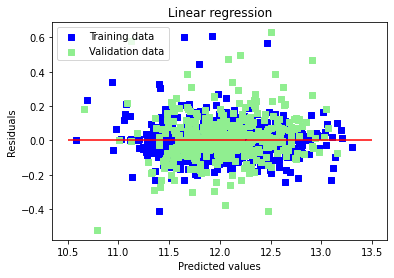

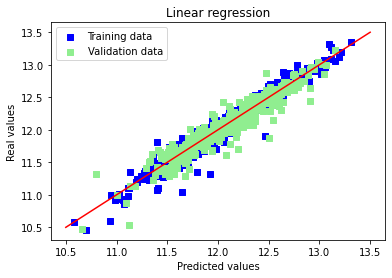

In [73]:
lr=LinearRegression()
lr.fit(X_train,y_train)

# Look at predictions on training and validation set
print("RMSE on Training set :", rmse_cv_train(lr).mean())
print("RMSE on Test set :", rmse_cv_test(lr).mean())

y_train_pred=lr.predict(X_train)
y_test_pred=lr.predict(X_test)

# 잔차=> 예측값-실제값
## x축 : 예측값, y축: 예측값-실제값
plt.scatter(y_train_pred, y_train_pred-y_train, c="blue", marker="s", label="Training data")
plt.scatter(y_test_pred, y_test_pred-y_test, c="lightgreen", marker="s", label="Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc="upper left")
plt.hlines(y=0, xmin=10.5, xmax=13.5, color="red")
plt.show()

# 예측값 그리기
# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

> Error는 센터 라인 주변으로 랜덤하게 분포되어있다. 그 의미는 이 모델이 대부분의 설명가능한 정보를 포함하고있다는것을 의미한다.

### 릿지
**2 * Linear Regression with Ridge regularization (L2 penalty)** 

### 라쏘
**3 * Linear Regression with Lasso regularization (L1 penalty)**



### ElasticNet
**4 * Linear Regression with ElasticNet regularization (L1 and L2 penalty)**

